In [ ]:
!pip install -r requirements.txt

In [ ]:
# ========================
# Cell 1: Model Processing
# ========================

import cv2
import json
import matplotlib.pyplot as plt
from ultralytics import YOLO
import tempfile
import os



Video Properties: 1920x1080, 20.121437752071976 FPS, 227 frames

0: 384x640 1 person, 1 backpack, 89.9ms
Speed: 2.4ms preprocess, 89.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 86.5ms
Speed: 2.7ms preprocess, 86.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 91.9ms
Speed: 0.0ms preprocess, 91.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 1 bed, 73.9ms
Speed: 1.2ms preprocess, 73.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 1 bed, 71.0ms
Speed: 2.4ms preprocess, 71.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 93.6ms
Speed: 2.5ms preprocess, 93.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 90.3ms
Speed: 1.3ms preprocess, 90.3ms inference, 0.0ms post

In [ ]:
model.train(data='dataset\\data.yaml', epochs=500, batch=256, imgsz=640)

In [ ]:

# Initialize YOLO model
model = YOLO('yolov10m.pt')  # Ensure the correct model is loaded
class_list = model.names

# Define the video processing function
def process_video(input_path):
    # Open video file
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        raise IOError("Error opening video file")

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Video Properties: {frame_width}x{frame_height}, {fps} FPS, {total_frames} frames")

    # Setup output video path and writer
    output_video_path = os.path.join(tempfile.gettempdir(), "output_video.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    # Initialize tracking data structures
    tracking_timestamps = {}
    disappearance_counts = {}
    debounce_limit = 10
    frame_buffer = {}
    tracking_data_json = []

    frame_number = 0

    # Process video frame by frame
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_number += 1
        timestamp = frame_number / fps
        results = model.predict(frame)
        detected_ids = []

        # Process detected objects
        if results and results[0].boxes is not None:
            for box in results[0].boxes.data.cpu().numpy():
                x1, y1, x2, y2, conf, cls = box
                if conf > 0.5 and int(cls) < len(class_list):
                    label = class_list[int(cls)]
                    object_id = int(cls)
                    detected_ids.append(object_id)

                    # Update tracking information
                    if object_id not in tracking_timestamps:
                        tracking_timestamps[object_id] = {
                            "class": label,
                            "trackId": object_id,
                            "startTime": timestamp,
                            "lastSeenTime": timestamp,
                            "detectedFrames": 1
                        }
                        disappearance_counts[object_id] = 0
                    else:
                        tracking_timestamps[object_id]["lastSeenTime"] = timestamp
                        tracking_timestamps[object_id]["detectedFrames"] += 1
                        disappearance_counts[object_id] = 0

                    # Draw bounding boxes
                    frame_buffer[object_id] = (int(x1), int(y1), int(x2), int(y2))
                    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                    cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Handle objects not detected in the current frame
        for obj_id in list(tracking_timestamps.keys()):
            if obj_id not in detected_ids:
                disappearance_counts[obj_id] += 1
                if disappearance_counts[obj_id] > debounce_limit:
                    # Record tracking data when object disappears
                    tracking_data_json.append({
                        "name": tracking_timestamps[obj_id]["class"],
                        "trackId": tracking_timestamps[obj_id]["trackId"],
                        "startTime": f"{tracking_timestamps[obj_id]['startTime']:.2f}s",
                        "endTime": f"{tracking_timestamps[obj_id]['lastSeenTime']:.2f}s",
                        "duration": f"{(tracking_timestamps[obj_id]['lastSeenTime'] - tracking_timestamps[obj_id]['startTime']):.2f}s",
                        "totalFramesDetected": tracking_timestamps[obj_id]["detectedFrames"]
                    })
                    # Remove the object from tracking once recorded
                    del tracking_timestamps[obj_id]
                    del disappearance_counts[obj_id]
                    del frame_buffer[obj_id]

        # Write processed frame to output video
        out.write(frame)

    # Finalize JSON tracking data for any remaining objects
    for obj_id in list(tracking_timestamps.keys()):
        tracking_data_json.append({
            "name": tracking_timestamps[obj_id]["class"],
            "trackId": tracking_timestamps[obj_id]["trackId"],
            "startTime": f"{tracking_timestamps[obj_id]['startTime']:.2f}s",
            "endTime": f"{tracking_timestamps[obj_id]['lastSeenTime']:.2f}s",
            "duration": f"{(tracking_timestamps[obj_id]['lastSeenTime'] - tracking_timestamps[obj_id]['startTime']):.2f}s",
            "totalFramesDetected": tracking_timestamps[obj_id]["detectedFrames"]
        })

    # Release resources
    cap.release()
    out.release()

    # Save tracking data to JSON file
    json_path = os.path.join(tempfile.gettempdir(), "tracking_data_output.json")
    with open(json_path, "w") as f:
        json.dump(tracking_data_json, f, indent=4)

    return output_video_path, json_path

# Provide the input video path (manually specify the path)
input_video_path = "test2.mp4"  # Change this path
output_video_path, json_file_path = process_video(input_video_path)

print(f"Output video saved to: {output_video_path}")
print(f"Tracking data JSON saved to: {json_file_path}")


C:\Users\irahu\AppData\Local\Temp\ipykernel_38248\2337274018.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_objects))


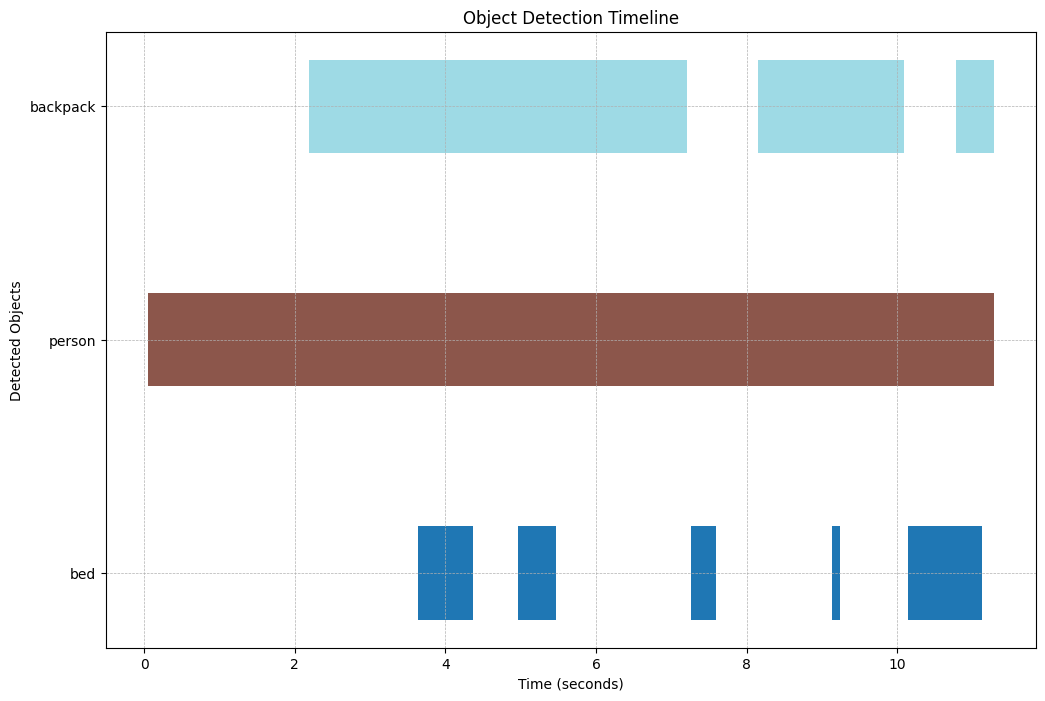

In [10]:
# ========================
# Cell 2: Graph Generation
# ========================

import json
import matplotlib.pyplot as plt
import os

# Load tracking data from JSON file
json_path = os.path.join(tempfile.gettempdir(), "tracking_data_output.json")
with open(json_path, "r") as f:
    tracking_data = json.load(f)

# print(f"Tracking Data: {tracking_data}")

# Generate a timeline graph of detected objects
unique_objects = list(set([item["name"] for item in tracking_data]))
object_intervals = []
object_names = []

# Extract intervals and object names for plotting
for obj in tracking_data:
    start_time = float(obj["startTime"][:-1])
    end_time = float(obj["endTime"][:-1])
    object_intervals.append((start_time, end_time))
    object_names.append(obj["name"])

# Map object names to indices for unique identification
name_to_idx = {name: idx for idx, name in enumerate(unique_objects)}
colors = plt.cm.get_cmap("tab20", len(unique_objects))

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))
for i, (start, end) in enumerate(object_intervals):
    idx = name_to_idx[object_names[i]]
    ax.broken_barh([(start, end - start)], (idx * 2 - 0.4, 0.8), facecolors=colors(idx))

# Customize plot appearance
ax.set_yticks([name_to_idx[name] * 2 for name in unique_objects])
ax.set_yticklabels(unique_objects)
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Detected Objects")
ax.grid(True, linestyle="--", linewidth=0.5)
ax.set_title("Object Detection Timeline")
plt.show()
